## Notebooks for keops exploring 

In [17]:
import torch
import matplotlib.pyplot as plt
from pykeops.torch import LazyTensor

Nous utilisons le GPU Apple Silicon (MPS) sur Mac pour accélérer les calculs, lorsque celui-ci est disponible. Cela permet d'exploiter la puissance de la puce graphique intégrée pour des traitements plus rapides, notamment lors de l'utilisation de bibliothèques comme PyTorch et KeOps.

In [2]:
device = torch.device("cpu")

La ligne suivante définit le type de données (`dtype`) utilisé pour les tenseurs PyTorch dans ce notebook. Ici, `torch.float32` indique que les valeurs des tenseurs seront stockées en précision flottante sur 32 bits, ce qui est généralement suffisant pour la plupart des calculs numériques tout en étant plus rapide et moins gourmand en mémoire que la précision double (`float64`).

In [3]:
dtype = torch.float32

Nous définissons ici les tailles des ensembles de points ainsi que la dimension des tenseurs :
- **N** : nombre de points d'évaluation \(x_i\)
- **M** : nombre de points sources \(y_j\)
- **d** : dimension (ou profondeur) des tenseurs, ici 2 pour des points en 2D

In [4]:
N, M, d = 3000, 3000, 2 

On définit ici deux tenseurs aléatoires `x` et `y` représentant des points en 2D, à l'aide de la fonction `torch.randn` de PyTorch.  
Chaque tenseur est créé avec la taille et le type de données spécifiés (`N`, `d`, `device`, `dtype`), ce qui permet de générer des ensembles de points adaptés aux calculs sur GPU ou CPU selon la configuration choisie.

In [5]:
x = torch.randn(N, d, device=device, dtype=dtype)
y = torch.randn(M, d, device=device, dtype=dtype)

Largeur du noyau gaussien 

In [6]:
sigma = 0.3

Création des lazy tenseurs à l'aide des tenseurs torch précédemment définis 

In [7]:
x_i = LazyTensor(x[:, None, :])   # (N, 1, d)
y_j = LazyTensor(y[None, :, :])   # (1, M, d)

La **formule du noyau gaussien** utilisée ici est :

$K_{ij} = \exp\left(-\frac{\|x_i - y_j\|^2}{2\sigma^2}\right)$

où :
- $( x_i )$ et $(y_j)$ sont des points en 2D (ou plus) définis par les tenseurs `x` et `y`.
- $( \|x_i - y_j\|^2 )$ représente la distance euclidienne au carré entre les points $( x_i )$ et $(y_j)$.
- $( \sigma )$ est la largeur du noyau gaussien (définie par la variable `sigma`).

Ce noyau mesure la similarité entre deux points : plus ils sont proches, plus la valeur du noyau est élevée (proche de 1). À l’inverse, si les points sont éloignés, la valeur du noyau tend vers 0. Cette fonction est largement utilisée en statistiques, machine learning et traitement du signal pour lisser ou pondérer des données en fonction de leur proximité.

In [8]:
D_ij = ((x_i - y_j) ** 2).sum(-1) #-> le sum(-1) effectue la 
#somme sur le dernier indice càd sur les j 

In [9]:
K_ij = (- D_ij / (2 * sigma**2)).exp()

Pour obtenir la densité locale $( f_i )$, on effectue la somme sur chaque ligne du noyau gaussien $( K_{ij} )$, c'est-à-dire sur l'indice \( j \) pour chaque point d'évaluation $( x_i )$ :

$
f_i = \sum_{j=1}^{M} K_{ij}$

Dans le code, cela correspond à :

```python
f = K_ij.sum(dim=1)
```

Chaque valeur $( f_i )$ représente la densité locale autour du point $( x_i )$, calculée à partir de la contribution de tous les points sources $( y_j )$ via le noyau gaussien.

In [10]:
f = K_ij.sum(dim=1)

Affichage 

In [11]:
print(f"\nf.shape = {f.shape}")
print(f"Type : {f.dtype}, Device : {f.device}")


f.shape = torch.Size([3000, 1])
Type : torch.float32, Device : cpu


Visualisation 2D 

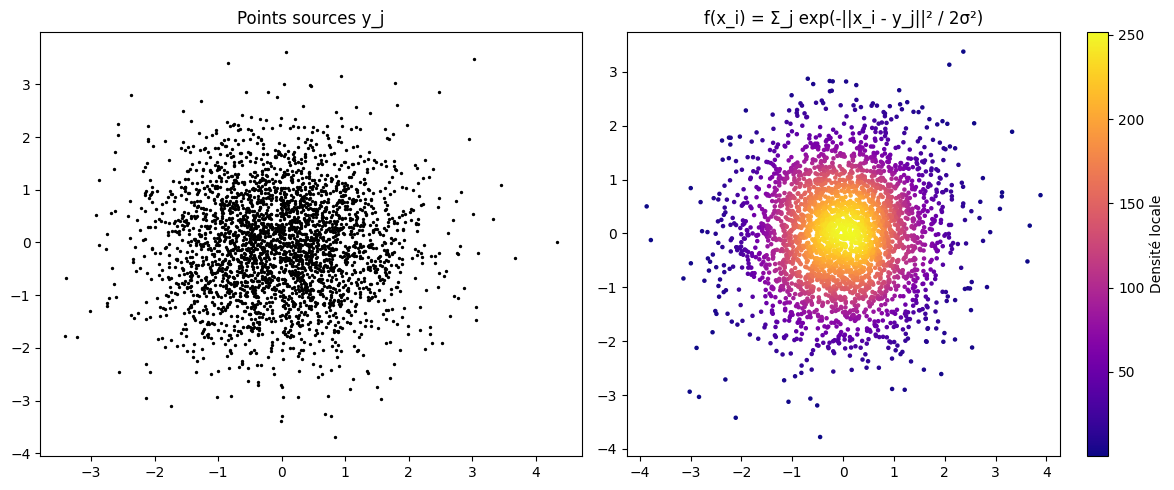

In [18]:
x_np = x.cpu().numpy()
y_np = y.cpu().numpy()
f_np = f.detach().cpu().numpy()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_np[:,0], y_np[:,1], color='black', s=2)
plt.title("Points sources y_j")

plt.subplot(1,2,2)
plt.scatter(x_np[:,0], x_np[:,1], c=f_np[:,0], cmap='plasma', s=5)
plt.title("f(x_i) = Σ_j exp(-||x_i - y_j||² / 2σ²)")
plt.colorbar(label="Densité locale")

plt.tight_layout()
plt.show()
